In [1]:
import h5py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# # Unistort the images using the camera properties
# # 1. get the camera intrinsics
# # 2. apply this every image in the "main" directory
# # 3. save the undistorted image in the "proc_main" directory

# # Obtain the file
# filename = "camera_intrinsics.h5"
# main_K, main_distortion = None, None

# #Extracts the intrinsic K matrix and distortion vector from the h5 file
# with h5py.File(filename, "r") as data:

#     main_K = np.array(data["main"]["K"])
#     main_distortion = np.array(data["main"]["distortion"])

# #Reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

# #Uses the intrinsics above to create an undistorted image and save it in a separate file under "proc_main"
# images = os.listdir("main")
# for file in images:
#     img = cv.imread("main/" + file)
#     if (img is not None):
#         h,  w = img.shape[:2]
#         newcameramtx, roi = cv.getOptimalNewCameraMatrix(main_K, main_distortion, (w,h), 1, (w,h))
#         undistorted = cv.undistort(img, main_K, main_distortion, None, newcameramtx)

#         # crop image
#         x, y, w, h = roi
#         undistorted = undistorted[y:y+h, x:x+w]

#         new_name = "proc_main/proc_" + file
#         cv.imwrite(new_name, undistorted)
    

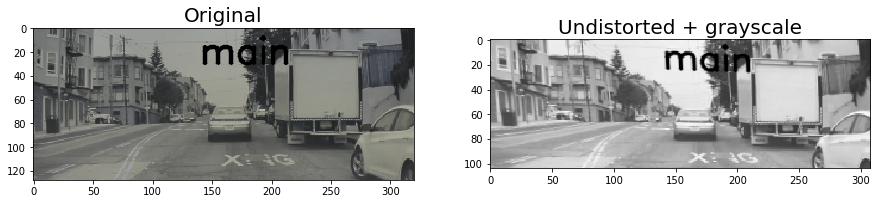

In [24]:
#plots the original and undistorted grayscale image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

image_name = "0844.png"

# original, distorted, image
original = cv.imread("main/" + image_name)

# undistorted image
undist = cv.imread("proc_main/proc_" + image_name)
gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)

ax[0].imshow(original)
ax[0].set_title('Original', fontsize=20)
ax[1].imshow(gray, cmap="gray")
ax[1].set_title('Undistorted + grayscale', fontsize=20);

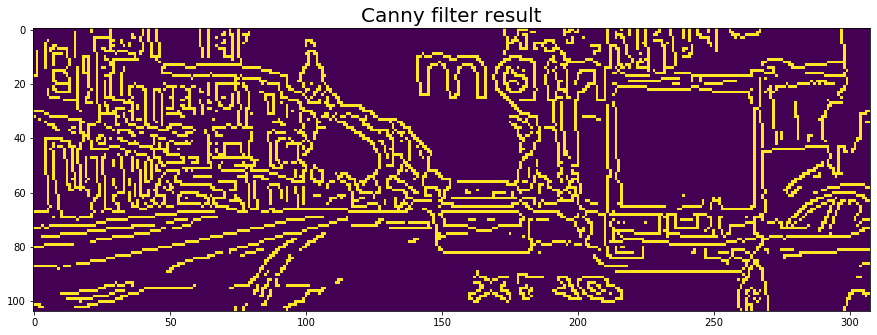

In [25]:
# (Unsuccessful) Canny Filter

# Blur the image to make borders more clear
blur_gray = cv.GaussianBlur(gray,(3, 3), 0)

# Apply Canny filter
img_can = cv.Canny(blur_gray, 45, 50) #threshold1 = 45, threshold2 = 50

plt.figure(figsize=(15, 12))
plt.imshow(img_can)
plt.title('Canny filter result', fontsize=20);

# REMARK: this is actually succesful, but we have to select only the region of the road. Is this possible?

In [26]:
# Sobel Filter
#https://medium.com/swlh/computer-vision-advanced-lane-detection-through-thresholding-8a4dea839179

# Apply Sobel in the x and y direction
# (previously, we used a x = 1 + y = 1 direction together)
sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0)
sobely = cv.Sobel(gray, cv.CV_64F, 0, 1)

# We have to take absolute value, otherwise negative gradients will be taken as 0 when converting to uint8
sobelx_abs = np.absolute(sobelx) 
sobely_abs = np.absolute(sobely)

conv_sobelx = np.uint8(255*sobelx_abs/np.max(sobelx_abs))
conv_sobely = np.uint8(255*sobely_abs/np.max(sobely_abs))

#create a binary mask of all zeroes, of the same size as the original image
binary = np.zeros_like(conv_sobelx)

# define sobel thresholds
x_min = 10
x_max = 100
y_min = 10
y_max = 100

#make binary pixel 1 if the sobelx and sobely pixel falls within the chosen threshold
binary[((conv_sobelx >= x_min) & (conv_sobelx <= x_max)) & ((conv_sobely >= y_min) & (conv_sobely <= y_max))] = 1

#make binary pixel 0 if it is outside of relevant image region
binary[0:60, :] = 0
binary[:, :50] = 0
binary[:, 250:] = 0


Text(0.5, 1.0, 'Binary for Sobel filter, filtered for region of interest')

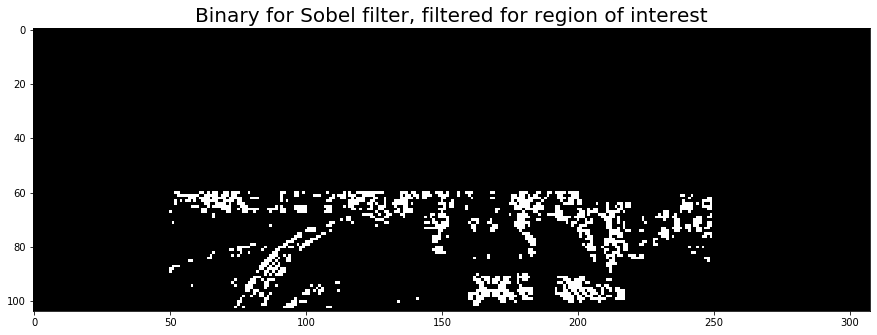

In [27]:
plt.figure(figsize=(15, 12))
plt.imshow(binary, cmap='gray')
plt.title('Binary for Sobel filter, filtered for region of interest', fontsize=20)

Text(0.5, 1.0, 'Hough Lines')

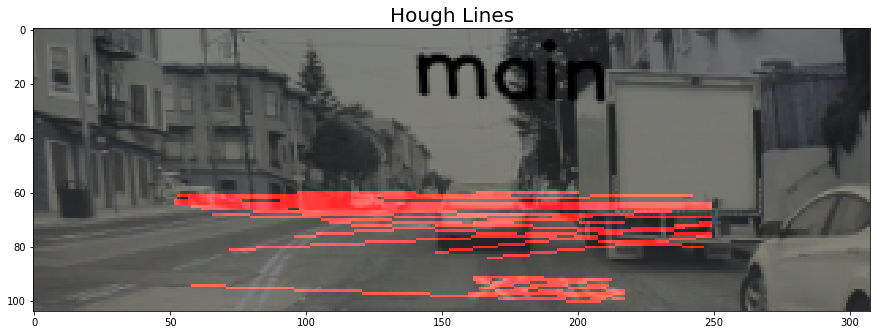

In [28]:
# (Unsuccesful) Hough Lines. Why? These lines are always linear, for one
# https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

#create empty image
line_image = np.copy(undist) * 0

# Hough Lines, rho=1 and threshold=1
lines = cv.HoughLinesP(binary, 1, np.pi/180, 25, np.array([]), minLineLength=30, maxLineGap=50)

# Add hough lines to canvas (each line is made up of two endpoints, x1, y1  and x2, y2)
for line in lines:
    for x1, y1, x2, y2 in line:
        pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
        cv.polylines(line_image, [pts], True, (255,0,0))
    
# Add the canvas w/ lines to the undistorted image and plot
lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)

plt.figure(figsize=(15, 12))
plt.imshow(lines_edges)
plt.title("Hough Lines", fontsize=20)

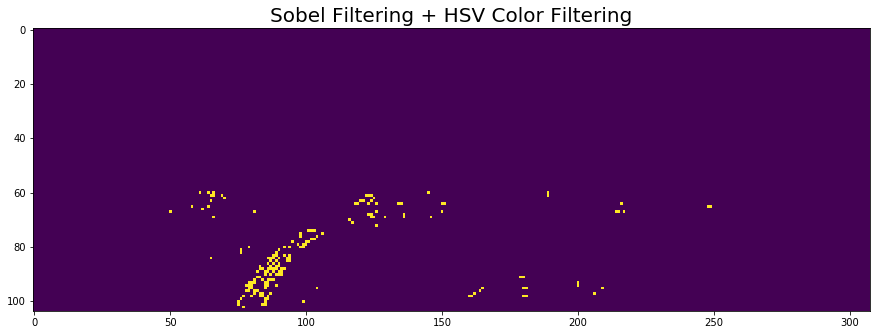

In [29]:
# Color Bounds method

# (Previously, we used RGB filtering)
# lower_bound = np.array([140, 140, 140]) #upper and lower RGB bounds
# upper_bound = np.array([148, 148, 148])

from scipy import optimize

# Define the hsv upper and lower bounds
hsv_upper = np.array([91, 15, 255])
hsv_lower = np.array([0, 0, 128])

# convert image to HSV format
hsv = cv.cvtColor(undist, cv.COLOR_BGR2HSV)

# find all pixels within this hsv range, in the relevant region of the image
in_bound = cv.inRange(hsv, hsv_lower, hsv_upper)

# Combine both the color filtering and sobol filtering
mask = in_bound & binary

plt.figure(figsize=(15, 12))
plt.imshow(mask)
plt.title('Sobel Filtering + HSV Color Filtering', fontsize=20);

C:\Users\knexk\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


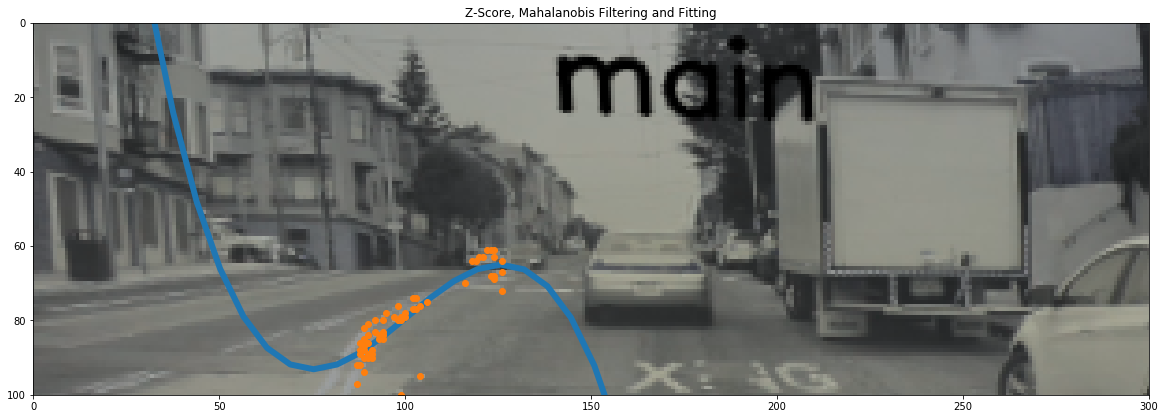

In [32]:
from scipy import stats
import scipy as sp

#extract coordinates of each nonzero pixel
pts = np.array([(x, y) for y in range(len(mask[0])) for x in range(len(mask)) if mask[x, y] > 0])
pts_y = [pt[1] for pt in pts]

z = np.abs(stats.zscore(pts_y))
z_pts = np.array([pts[i] for i in range(len(pts)) if z[i] < np.median(z)])


C_inv = sp.linalg.inv(np.cov(z_pts.T))
alpha = pts - np.mean(z_pts)
a_dot_Cinv = np.dot(alpha, C_inv)
inner = np.dot(a_dot_Cinv, alpha.T)
mahalanobis = np.sqrt(inner)
md = np.sqrt(mahalanobis.diagonal())

true_C = np.sqrt(stats.chi2.ppf(1 -.001, df=z_pts.shape[1]))
f_pts = [z_pts[i] for i in range(len(z_pts)) if md[i] < np.median(md)]
f_ptsx = [pt[0] for pt in f_pts]
f_ptsy = [pt[1] for pt in f_pts]

fit = np.polyfit(f_ptsy, f_ptsx, 3)
curve = np.poly1d(fit)
x_range = np.linspace(0, len(mask[0]))
y_range = curve(x_range)

plt.figure(figsize=(20, 15))
plt.plot(x_range, y_range, linewidth=6)
plt.xlim(0, 300)
plt.ylim(0, 100)

plt.imshow(undist)
plt.title("Z-Score, Mahalanobis Filtering and Fitting")
plt.plot(f_ptsy, f_ptsx, "o")
plt.gca().invert_yaxis()


Text(0.5, 1.0, 'Hough Lines')

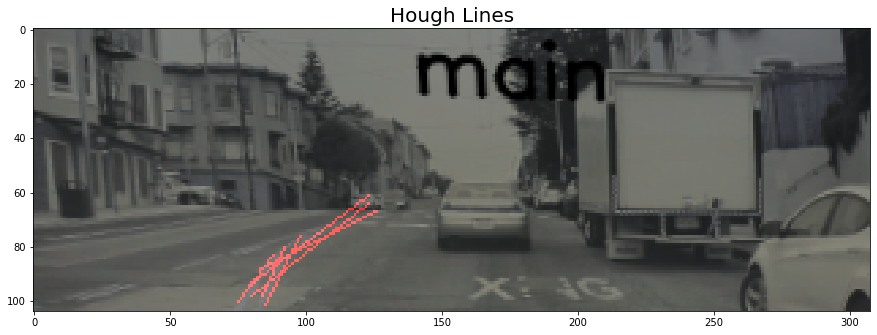

In [36]:
# (Unsuccesful) Hough Lines. Why? These lines are always linear, for one
# https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

#create empty image
line_image = np.copy(undist) * 0

# Hough Lines, rho=1 and threshold=1
lines = cv.HoughLinesP(mask, 1, np.pi/180, 10, np.array([]), minLineLength=10, maxLineGap=50)

# Add hough lines to canvas (each line is made up of two endpoints, x1, y1  and x2, y2)
for line in lines:
    for x1, y1, x2, y2 in line:
        pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
        cv.polylines(line_image, [pts], True, (255,0,0))
    
# Add the canvas w/ lines to the undistorted image and plot
lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)

plt.figure(figsize=(15, 12))
plt.imshow(lines_edges)
plt.title("Hough Lines", fontsize=20)

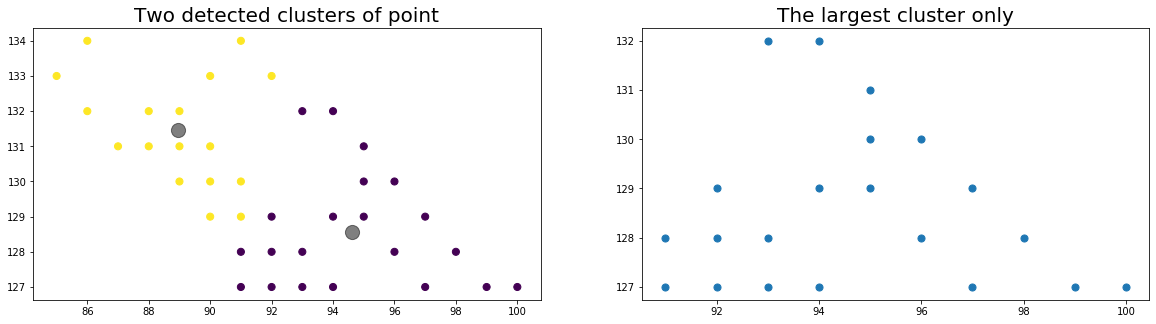

In [18]:
# Trying to extract only the useful points by clustering + filtering them

from sklearn.cluster import KMeans

# Setup an object for 2 clusters
kmeans = KMeans(n_clusters=2)
km_results = kmeans.fit(f_pts)
y_kmeans = kmeans.predict(f_pts)

# plot the two found clusters and the largest one
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

# plot the resulting 2 clusters and their centers
ax[0].scatter(f_ptsx, f_ptsy, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax[0].set_title('Two detected clusters of point', fontsize=20);

# find out what the index (either 0 or 1) of the largest cluster is 
# (i.e. the one with the most points)
# ASSUMPTION: the line we want to detect has the most points
largest_cluster_number = np.argmax(np.bincount(km_results.labels_))

# filter and retain only those points that belong to the largest cluster
filtered_pts = np.array([(x[0], x[1]) for ind, x in enumerate(f_pts) if km_results.labels_[ind] == largest_cluster_number])

# show this largest cluster
ax[1].scatter(filtered_pts[:, 0], filtered_pts[:, 1], s=50, cmap='viridis')
ax[1].set_title('The largest cluster only', fontsize=20);

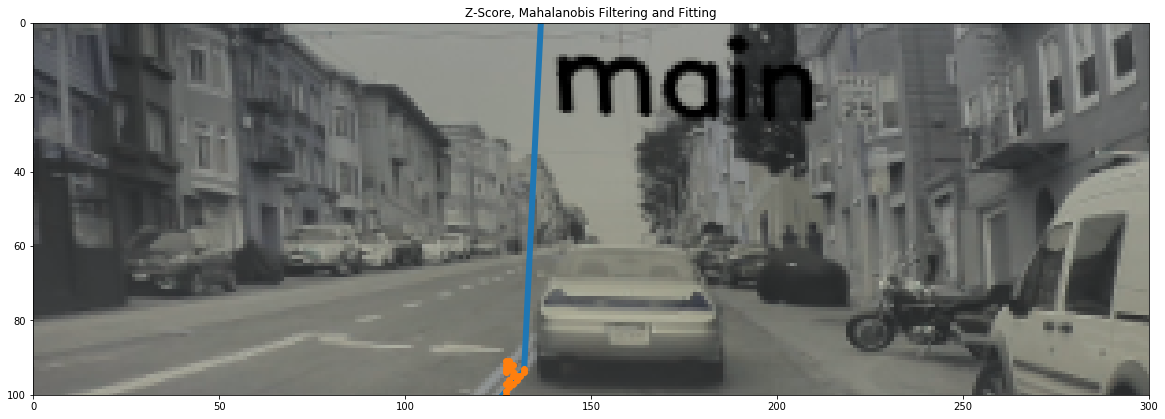

In [20]:
filtered_ptsx = [f[0] for f in filtered_pts]
filtered_ptsy = [f[1] for f in filtered_pts]

fit = np.polyfit(filtered_ptsy, filtered_ptsx, 3)
curve = np.poly1d(fit)
x_range = np.linspace(0, len(mask[0]))
y_range = curve(x_range)

plt.figure(figsize=(20, 15))
plt.plot(x_range, y_range, linewidth=6)
plt.xlim(0, 300)
plt.ylim(0, 100)

plt.imshow(undist)
plt.title("Z-Score, Mahalanobis Filtering and Fitting")
plt.plot(filtered_ptsy, filtered_ptsx, "o")
plt.gca().invert_yaxis()


In [21]:
# filtered_ptsy = [pt[0] for pt in filtered_pts]
# filtered_ptsx = [pt[1] for pt in filtered_pts]

# fit = np.polyfit(filtered_ptsy, filtered_ptsx, 1)
# curve = np.poly1d(fit)
# x_range = np.linspace(0, len(mask[0]))
# y_range = curve(x_range)

# plt.figure(figsize=(20, 15))
# plt.plot(y_range, x_range, linewidth=6)
# plt.xlim(0, 300)
# plt.ylim(0, 100)

# plt.imshow(undist)
# plt.plot(filtered_ptsx, filtered_ptsy, "o")
# plt.gca().invert_yaxis()

In [12]:
# # Load image
# import cv2
# image = undist
# def nothing(x):
#     pass
# # Create a window
# cv2.namedWindow('image')
# cv2.namedWindow('pic')
# # Create trackbars for color change
# # Hue is from 0-179 for Opencv
# cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# # Set default value for Max HSV trackbars
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize HSV min/max values
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# while(1):
#     # Get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin', 'image')
#     sMin = cv2.getTrackbarPos('SMin', 'image')
#     vMin = cv2.getTrackbarPos('VMin', 'image')
#     hMax = cv2.getTrackbarPos('HMax', 'image')
#     sMax = cv2.getTrackbarPos('SMax', 'image')
#     vMax = cv2.getTrackbarPos('VMax', 'image')

#     # Set minimum and maximum HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Convert to HSV format and color threshold
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     result = cv2.bitwise_and(image, image, mask=mask)

#     # Print if there is a change in HSV value
#     if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display result image
#     cv2.imshow('pic', result)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()